In [64]:
import pandas as pd
import numpy as np
import sklearn
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

In [2]:
pd.set_option('display.float_format', lambda x: '%3f' % x)
covid_df = pd.read_csv("covid-tests-cases-deaths-per-million.csv")

In [3]:
# Acquire USA dataset, remove uneeded columns
US_df = covid_df[covid_df["Entity"] == "United States"]
del US_df["total_tests_per_thousand Annotations"], US_df["Entity"], US_df["Code"], US_df["Date"]

# Add new columns and reformat old ones
USA_pop = 328200000
US_df = US_df.fillna(0)
US_df["new tests per thousand"] = US_df["total_tests_per_thousand"] - US_df["total_tests_per_thousand"].shift(1)
US_df["new confirmed cases per million people"] = US_df["Total confirmed cases of COVID-19 per million people"] - US_df["Total confirmed cases of COVID-19 per million people"].shift(1)
US_df["new confirmed deaths per million people"] = US_df["Total confirmed deaths due to COVID-19 per million people"] - US_df["Total confirmed deaths due to COVID-19 per million people"].shift(1)
US_df["total confirmed cases"] = US_df["Total confirmed cases of COVID-19 per million people"] * USA_pop / 1000000
US_df["total confirmed deaths"] = US_df["Total confirmed deaths due to COVID-19 per million people"] * USA_pop / 1000000
US_df["total confirmed deaths"] = US_df["total confirmed deaths"].round(0)
US_df["total confirmed cases"] = US_df["total confirmed cases"].round(0)
US_df["new confirmed cases"] = US_df["total confirmed cases"] - US_df["total confirmed cases"].shift(1)
US_df["new deaths"] = US_df["total confirmed deaths"] - US_df["total confirmed deaths"].shift(1)
US_df["day"] = np.arange(len(US_df))


US_df = US_df[US_df["day"] < 360]

US_df = US_df.fillna(0)
US_df.reset_index(drop=True, inplace=True)
US_df.head(1000)

,total_tests_per_thousand,Total confirmed cases of COVID-19 per million people,Total confirmed deaths due to COVID-19 per million people,new tests per thousand,new confirmed cases per million people,new confirmed deaths per million people,total confirmed cases,total confirmed deaths,new confirmed cases,new deaths,day
0,0.000000,0.003000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0
1,0.000000,0.003000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1
2,0.000000,0.006000,0.000000,0.000000,0.003000,0.000000,2.000000,0.000000,1.000000,0.000000,2
3,0.000000,0.006000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,3
4,0.000000,0.015000,0.000000,0.000000,0.009000,0.000000,5.000000,0.000000,3.000000,0.000000,4
...,...,...,...,...,...,...,...,...,...,...,...
355,808.429000,68348.006000,1136.979000,3.978000,644.418000,6.061000,22431816.000000,373157.000000,211498.000000,1990.000000,355
356,813.399000,69029.037000,1150.459000,4.970000,681.031000,13.480000,22655330.000000,377581.000000,223514.000000,4424.000000,356
357,817.739000,69724.397000,1162.432000,4.340000,695.360000,11.973000,22883547.000000,381510.000000,228217.000000,3929.000000,357
358,821.479000,70436.056000,1174.302000,3.740000,711.659000,11.870000,23117114.000000,385406.000000,233567.000000,3896.000000,358


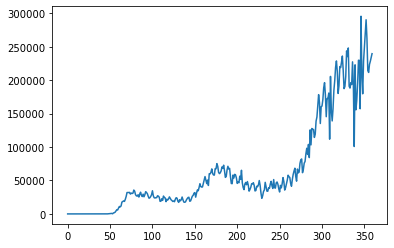

In [4]:
plt.figure()
plt.plot(US_df["day"], US_df["new confirmed cases"])

In [33]:
# Set up time series for RNN/LSTM input
def build_timeseries(dataframe, lookback, col):
    xData, yData = [], []
    tempX = dataframe.copy()
    tempY = tempX.pop(col)
    for i in range(len(dataframe)-lookback-1):
        x = dataframe.values[i:(i+lookback)]
        y = tempY.values[i+lookback]
        xData.append(x)
        yData.append(y)
    return np.array(xData), np.array(yData)

In [85]:
# Split data into Train/Validation/Test
splitTr = int(0.7 * len(US_df))
splitVal = int(0.85 * len(US_df))

train = US_df[:splitTr]
val = US_df[splitTr:splitVal]
test = US_df[splitVal:]

# how many prior days to look at when making a prediction
timestep = 20

# xData is in shape (samples, timesteps, features)
xTr, yTr = build_timeseries(train, timestep, "new confirmed cases")
xVal, yVal = build_timeseries(val, timestep, "new confirmed cases")
xTest, yTest = build_timeseries(test, timestep, "new confirmed cases")

In [67]:
# Hyperparameters
optimizer= keras.optimizers.Adam(learning_rate=0.005)

# Start building the modoel

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, dropout=0.2, input_shape=(timestep, 11)))
model.add(LSTM(units=50, return_sequences=True, dropout=0.2))
model.add(LSTM(units=50, dropout=0.2))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='relu'))
model.compile(loss='mean_squared_error', optimizer=optimizer)
print(model.summary())

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_34 (LSTM)               (None, 20, 50)            12400     
_________________________________________________________________
lstm_35 (LSTM)               (None, 20, 50)            20200     
_________________________________________________________________
lstm_36 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_28 (Dense)             (None, 100)               5100      
_________________________________________________________________
dense_29 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_30 (Dense)             (None, 20)                1020      
_________________________________________________________________
dense_31 (Dense)             (None, 1)               

In [68]:
model.fit(xTr, yTr, epochs=20, validation_data=(xVal,yVal), batch_size=10, verbose=1)

Train on 230 samples, validate on 34 samples
Epoch 1/20
230/230 [==============================] - 1s 6ms/step - loss: 1319543513.0435 - val_loss: 15406596156.2353
Epoch 2/20
230/230 [==============================] - 1s 2ms/step - loss: 1165073694.6087 - val_loss: 13657097968.9412
Epoch 3/20
230/230 [==============================] - 1s 2ms/step - loss: 455746102.2609 - val_loss: 7276526524.2353
Epoch 4/20
230/230 [==============================] - 1s 2ms/step - loss: 278427734.7826 - val_loss: 9373731373.1765
Epoch 5/20
230/230 [==============================] - 1s 2ms/step - loss: 426348552.6957 - val_loss: 7841700306.8235
Epoch 6/20
230/230 [==============================] - 1s 2ms/step - loss: 196009809.7391 - val_loss: 8057135171.7647
Epoch 7/20
230/230 [==============================] - 1s 2ms/step - loss: 242672388.8696 - val_loss: 10648335631.0588
Epoch 8/20
230/230 [==============================] - 1s 2ms/step - loss: 396275690.4348 - val_loss: 7770521238.5882
Epoch 9/20
230

In [74]:
preds = model.predict(xTest)
for i in range(len(preds)):
    print(preds[i], yTest[i], "diff=", abs(preds[i]-yTest[i]))

[30661.555] 187275.0 diff= [156613.44]
[30661.555] 190442.0 diff= [159780.44]
[30661.555] 205651.0 diff= [174989.44]
[30661.555] 243702.0 diff= [213040.44]
[30661.555] 235214.0 diff= [204552.44]
[30661.555] 248098.0 diff= [217436.44]
[30661.555] 190898.0 diff= [160236.44]
[30661.555] 188138.0 diff= [157476.44]
[30661.555] 196197.0 diff= [165535.44]
[30661.555] 193382.0 diff= [162720.44]
[30661.555] 227319.0 diff= [196657.44]
[30661.555] 192538.0 diff= [161876.44]
[30661.555] 100761.0 diff= [70099.445]
[30661.555] 222858.0 diff= [192196.44]
[30661.555] 155597.0 diff= [124935.445]
[30661.555] 169858.0 diff= [139196.44]
[30661.555] 194513.0 diff= [163851.44]
[30661.555] 229754.0 diff= [199092.44]
[30661.555] 229510.0 diff= [198848.44]
[30661.555] 157207.0 diff= [126545.445]
[30661.555] 295508.0 diff= [264846.44]
[30661.555] 207732.0 diff= [177070.44]
[30661.555] 179539.0 diff= [148877.44]
[30661.555] 228477.0 diff= [197815.44]
[30661.555] 249651.0 diff= [218989.44]
[30661.555] 272697.0 di